### Importing Dependencies

In [1]:
import matplotlib.pyplot as plt

In [2]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [3]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [4]:
from datasets import Dataset

train_ds = Dataset.from_dict({ 'text': processed_texts, 'label': labels })
val_ds = Dataset.from_dict({ 'text': processed_val_texts, 'label': val_labels })

In [5]:
train_ds[0]

{'text': 'vent life take turn go discord Dran#1230 dran#1230 discord get chest rn',
 'label': 1.0}

### Creating the Model

#### Vectorization

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert/distilbert-base-uncased')

In [7]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

In [8]:
tokenized_texts = train_ds.map(preprocess_function, batched=True)
tokenized_val_texts = val_ds.map(preprocess_function, batched=True)


Map:   0%|          | 0/625011 [00:00<?, ? examples/s]

Map:   0%|          | 0/78127 [00:00<?, ? examples/s]

In [9]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

2024-07-14 02:57:52.077599: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-14 02:57:52.084499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 02:57:52.094365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 02:57:52.094379: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 02:57:52.101000: I tensorflow/core/platform/cpu_feature_gua

### Evaluate

In [10]:
import evaluate

accuracy = evaluate.load("accuracy")

In [11]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

#### Creating the model

In [12]:
id2label = {0: "Depressed", 1: "Happy"}
label2id = {"Depressed": 0, "Happy": 1}

In [13]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 8
batches_per_epoch = len(tokenized_texts) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

2024-07-14 02:57:54.059954: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-14 02:57:54.075809: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-14 02:57:54.086214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [14]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [15]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_texts,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_val_set = model.prepare_tf_dataset(
    tokenized_val_texts,
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

In [16]:
import tensorflow as tf

model.compile(optimizer=optimizer)

In [17]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_val_set)

In [18]:
callbacks = [metric_callback]

In [19]:
model.fit(x=tf_train_set, validation_data=tf_val_set, epochs=num_epochs, callbacks=callbacks)

Epoch 1/8
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1720940288.108438   18839 service.cc:145] XLA service 0x798f55785f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720940288.108452   18839 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-07-14 02:58:08.117026: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-14 02:58:08.132471: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1720940288.168513   18839 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


39063/39063 [==============================] - 7152s 183ms/step - loss: 0.3384 - val_loss: 0.3134 - accuracy: 0.8608
Epoch 2/8


2024-07-14 04:57:06.659341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


39063/39063 [==============================] - 7108s 182ms/step - loss: 0.2709 - val_loss: 0.3186 - accuracy: 0.8628
Epoch 3/8


2024-07-14 06:55:34.925576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


39063/39063 [==============================] - 7085s 181ms/step - loss: 0.2082 - val_loss: 0.3342 - accuracy: 0.8649
Epoch 4/8


2024-07-14 08:53:39.951387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


39063/39063 [==============================] - 7044s 180ms/step - loss: 0.1480 - val_loss: 0.3949 - accuracy: 0.8619
Epoch 5/8


2024-07-14 10:51:04.471412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27484/39063 [====================>.........] - ETA: 32:23 - loss: 0.1007

KeyboardInterrupt: 

### Evaluating the Model

In [20]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
test_ds = Dataset.from_dict({ 'text': processed_test_texts, 'label': test_labels })
tokenized_test_texts = test_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/70314 [00:00<?, ? examples/s]

In [22]:
tokenized_test_texts = [tokenizer(text, truncation=True, return_tensors='tf') for text in processed_test_texts]

In [25]:
len(tokenized_test_texts)

70314

In [26]:
logits = [model(**tokenized_test_text).logits for tokenized_test_text in tokenized_test_texts[:700]]

In [27]:
y_pred = [int(tf.math.argmax(logit, axis=-1)[0]) for logit in logits]
# y_pred = (y_pred > 0.5).astype(int)

# y_pred = np.array(list(map(lambda x: x[0], y_pred)))

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tn, fp, fn, tp = confusion_matrix(test_labels[:700], y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

print(f'accuracy_score {accuracy_score(test_labels[:700], y_pred):.3f}')
print(f'precision_score {precision_score(test_labels[:700], y_pred):.3f}')
print(f'recall_score {recall_score(test_labels[:700], y_pred):.3f}')
print(f'f1_score {f1_score(test_labels[:700], y_pred):.3f}')

False Positive Rate: 0.1314
False Negative Rate: 0.1842
accuracy_score 0.851
precision_score 0.750
recall_score 0.816
f1_score 0.782


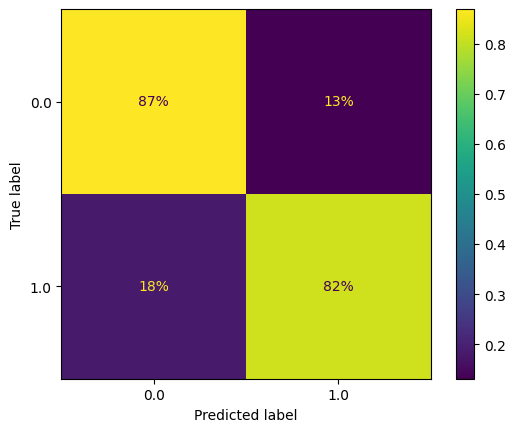

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels[:700], y_pred, normalize="true",
                                        values_format=".0%")
plt.show()

In [33]:
import pickle

with open('./models/hug_clf.pkl', 'wb') as fp:
  pickle.dump(model, fp)

with open('./models/hug_tok.pkl', 'wb') as fp:
  pickle.dump(tokenizer, fp)

/home/peizhe/Documents/Coding/reddit_depression_analysis/.venv/lib/python3.12/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)
